<a href="https://colab.research.google.com/github/vinayjoshva/Colab-PyTorch-NeuralNetwork/blob/main/Practical_4_(16352584).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd

# Load the dataset
file_path = "Mens Fashion.csv"  # Update this path as needed
df = pd.read_csv(file_path)

# Display the first few rows to inspect the structure
print(df.head())

                                                name main_category  \
0                        Sparx mens Sd9039g Sneakers        stores   
1  WildHorn Brown RFID Blocking Leather Wallet fo...        stores   
2  Casio Vintage Series Digital Grey Dial Men's W...        stores   
3  SJeware Men & Women Solid Ankle Length Socks (...        stores   
4  Fashion Frill Men's Double Coated Popular Stai...        stores   

    sub_category                                              image  \
0  Men's Fashion  https://m.media-amazon.com/images/I/51e48JV2Gf...   
1  Men's Fashion  https://m.media-amazon.com/images/I/81vMec1lk+...   
2  Men's Fashion  https://m.media-amazon.com/images/I/61ybeKQto8...   
3  Men's Fashion  https://m.media-amazon.com/images/I/61r8Z4tDkv...   
4  Men's Fashion  https://m.media-amazon.com/images/I/61cY9DOK2X...   

                                                link ratings no_of_ratings  \
0  https://www.amazon.in/Sparx-Casual-Stripped-Sn...     4.0         1,893

In [27]:
# Selecting relevant features
features = ["ratings", "no_of_ratings", "discount_price", "actual_price"]
df_selected = df[features].copy()

In [28]:
# Function to clean and convert columns to numeric
def clean_numeric(column):
    return pd.to_numeric(column.astype(str).str.replace(r"[^\d.]", "", regex=True), errors='coerce')

# Apply the function to clean and convert numeric columns
df_selected["no_of_ratings"] = clean_numeric(df_selected["no_of_ratings"])
df_selected["discount_price"] = clean_numeric(df_selected["discount_price"])
df_selected["actual_price"] = clean_numeric(df_selected["actual_price"])
df_selected["ratings"] = pd.to_numeric(df_selected["ratings"], errors='coerce')  # Convert ratings to float

# Fill missing values with median
df_selected.fillna(df_selected.median(), inplace=True)

# Display cleaned data
print(df_selected.head())

   ratings  no_of_ratings  discount_price  actual_price
0      4.0         1893.0           499.0         999.0
1      4.0        33466.0           285.0        1499.0
2      4.4        29931.0           524.0        1695.0
3      3.3         1212.0           145.0         399.0
4      4.1          721.0           179.0         998.0


In [29]:
# Filling missing values with median
df_selected.fillna(df_selected.median(), inplace=True)

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the data
df_scaled = scaler.fit_transform(df_selected)

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=features)


In [31]:
import numpy as np

sequence_length = 5  # Number of past observations to consider

# Creating sequences
X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled.iloc[i:i+sequence_length].values)  # Past 'sequence_length' records
    y.append(df_scaled.iloc[i+sequence_length].values)    # Next value

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

print(f"Input Shape: {X.shape}, Target Shape: {y.shape}")


Input Shape: (19195, 5, 4), Target Shape: (19195, 4)


In [32]:
import torch

# Convert data into PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

print(f"Tensor Shape - X: {X_tensor.shape}, y: {y_tensor.shape}")


Tensor Shape - X: torch.Size([19195, 5, 4]), y: torch.Size([19195, 4])


#Defining RNN

In [33]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take only the last output
        return out


In [34]:
import matplotlib.pyplot as plt

def train_model_with_tracking(model, X_train, y_train, epochs=20, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []  # Store loss per epoch

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Track loss

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

    return model, losses


In [35]:
input_size = 4  # Number of features
hidden_size = 64  # Can be adjusted
output_size = 4  # Number of output features

rnn_model = RNNModel(input_size, hidden_size, output_size)
rnn_model = train_model_with_tracking(rnn_model, X_tensor, y_tensor)

Epoch [5/20], Loss: 0.124528
Epoch [10/20], Loss: 0.036272
Epoch [15/20], Loss: 0.008316
Epoch [20/20], Loss: 0.018680


#LSTM Model

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take only the last output
        return out


In [37]:
lstm_model = LSTMModel(input_size, hidden_size, output_size)
lstm_model = train_model_with_tracking(lstm_model, X_tensor, y_tensor)


Epoch [5/20], Loss: 0.113514
Epoch [10/20], Loss: 0.087512
Epoch [15/20], Loss: 0.061786
Epoch [20/20], Loss: 0.036242


#GRU Model

In [38]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take only the last output
        return out


In [39]:
gru_model = GRUModel(input_size, hidden_size, output_size)
gru_model = train_model_with_tracking(gru_model, X_tensor, y_tensor)


Epoch [5/20], Loss: 0.137732
Epoch [10/20], Loss: 0.091815
Epoch [15/20], Loss: 0.051862
Epoch [20/20], Loss: 0.020246


In [40]:
rnn_model, rnn_losses = train_model_with_tracking(RNNModel(input_size, hidden_size, output_size), X_tensor, y_tensor)
lstm_model, lstm_losses = train_model_with_tracking(LSTMModel(input_size, hidden_size, output_size), X_tensor, y_tensor)
gru_model, gru_losses = train_model_with_tracking(GRUModel(input_size, hidden_size, output_size), X_tensor, y_tensor)


Epoch [5/20], Loss: 0.125602
Epoch [10/20], Loss: 0.061676
Epoch [15/20], Loss: 0.012767
Epoch [20/20], Loss: 0.013039
Epoch [5/20], Loss: 0.154131
Epoch [10/20], Loss: 0.119478
Epoch [15/20], Loss: 0.084670
Epoch [20/20], Loss: 0.049699
Epoch [5/20], Loss: 0.064612
Epoch [10/20], Loss: 0.037127
Epoch [15/20], Loss: 0.016887
Epoch [20/20], Loss: 0.006106


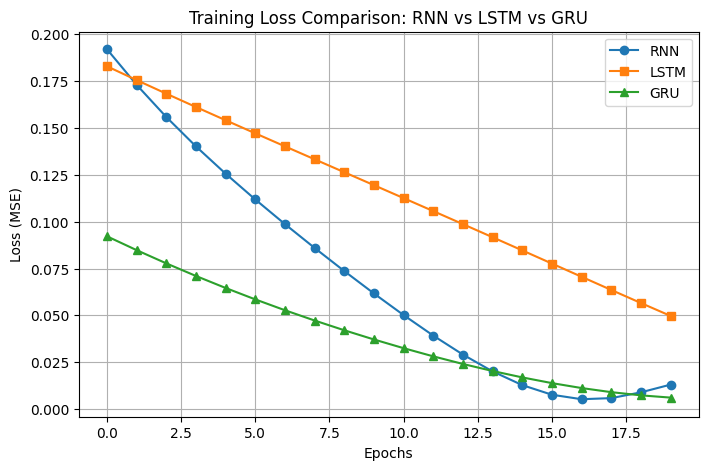

In [41]:
plt.figure(figsize=(8, 5))

plt.plot(rnn_losses, label="RNN", marker="o")
plt.plot(lstm_losses, label="LSTM", marker="s")
plt.plot(gru_losses, label="GRU", marker="^")

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Comparison: RNN vs LSTM vs GRU")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
pip install transformers


In [43]:
from transformers import pipeline

# Load a better model (GPT-2)
explainer = pipeline("text-generation", model="gpt2")

# Define new prompts
prompts = [
    "Why does RNN perform worse than LSTM and GRU in sequential data processing?",
    "Why does LSTM handle long-term dependencies better than RNN?",
    "Why does GRU train faster than LSTM while maintaining similar performance?"
]

# Generate explanations
for prompt in prompts:
    explanation = explainer(prompt, max_length=100, truncation=True)
    print(f"\nPrompt: {prompt}\nExplanation: {explanation[0]['generated_text']}")


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Why does RNN perform worse than LSTM and GRU in sequential data processing?
Explanation: Why does RNN perform worse than LSTM and GRU in sequential data processing? The answer is, yes, indeed it does. RNN does exactly the same job in the same way, with a different approach. The problem is, it can't use LSTM. As a general rule, RNN has no use for RNN-like data processing, and it can't do that any better than LSTM.

LSTM's and GRU's advantage



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Why does LSTM handle long-term dependencies better than RNN?
Explanation: Why does LSTM handle long-term dependencies better than RNN?

I've seen different implementations of LSTM in other languages (like Julia and Go), but for a long time I simply didn't understand the concepts of dependency modeling. Even though I know that this is a common practice within the RNN community, many of the discussions regarding LSTM actually stem from the use of recursive dependencies. This isn't the first mistake that I've had on these projects.



Prompt: Why does GRU train faster than LSTM while maintaining similar performance?
Explanation: Why does GRU train faster than LSTM while maintaining similar performance? Is it true?

Most of us take GRU to the next level when we play a game of Counter-Strike with multiple players. As people come to terms with the fact that the amount of time they can spend playing is so vast that I rarely use it, I have decided to try and use it rather than spend t

#Accuracy evaluation for each model

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test):
    with torch.no_grad():  # Disable gradient calculation for efficiency
        predictions = model(X_test).numpy()  # Get model predictions
        actuals = y_test.numpy()  # Convert targets to numpy

    # Compute evaluation metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae}


In [45]:
rnn_results = evaluate_model(rnn_model, X_tensor, y_tensor)
lstm_results = evaluate_model(lstm_model, X_tensor, y_tensor)
gru_results = evaluate_model(gru_model, X_tensor, y_tensor)

# Print results
print("\n🔹 RNN Evaluation:", rnn_results)
print("\n🔹 LSTM Evaluation:", lstm_results)
print("\n🔹 GRU Evaluation:", gru_results)



🔹 RNN Evaluation: {'MSE': 0.01627640426158905, 'RMSE': 0.1275790118381117, 'MAE': 0.07292491942644119}

🔹 LSTM Evaluation: {'MSE': 0.0429607518017292, 'RMSE': 0.20726975611923995, 'MAE': 0.11823711544275284}

🔹 GRU Evaluation: {'MSE': 0.00540927005931735, 'RMSE': 0.07354774000142594, 'MAE': 0.037995845079422}
